<a href="https://colab.research.google.com/github/nissrinayy/deeplearning/blob/main/Week1/income_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving income.csv to income.csv


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from scipy.special import softmax
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

In [3]:
# Load dataset
df = pd.read_csv("income.csv")

# Cek data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB
None


In [4]:
pd.set_option('display.max_columns', None)
print(df.head())

   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0             

In [5]:
df = df.copy()
print("Unique income classes:", df['income'].unique())


Unique income classes: ['<=50K' '>50K' '<=50K.' '>50K.']


In [6]:
# Gunakan LabelEncoder untuk mengonversi target ke kelas 0,1,2,3
le = LabelEncoder()
df['income'] = le.fit_transform(df['income'])

# Encode semua fitur kategorikal
categorical_cols = ['workclass', 'education', 'marital-status', 'occupation',
                    'relationship', 'race', 'sex', 'native-country']
for col in categorical_cols:
    df.loc[:, col] = LabelEncoder().fit_transform(df[col])


In [7]:
# Pisahkan fitur dan target
X = df.drop(columns=['income'])
y = df['income']

scaler = StandardScaler()
X = scaler.fit_transform(X)


In [8]:
# Bagi dataset menjadi training dan testing (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [9]:
# === 3. Terapkan SMOTE (Menyeimbangkan Data) ===
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Hitung class weight untuk training
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

In [10]:
# === 3. Terapkan Oversampling dan Augmentasi Data ===
from imblearn.over_sampling import RandomOverSampler

# 1️⃣ **Oversampling untuk Menyeimbangkan Data**
oversample = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train, y_train = oversample.fit_resample(X_train, y_train)

# 2️⃣ **Jittering (Menambahkan Noise Kecil)**
noise = np.random.normal(0, 0.02, X_train.shape)  # Gaussian Noise
scale_variation = np.random.uniform(0.9, 1.1, X_train.shape)  # Variasi skala fitur

# 3️⃣ **Gaussian Noise Dropout (Simulasi Missing Values)**
dropout_mask = np.random.choice([0, 1], size=X_train.shape, p=[0.05, 0.95])  # 5% fitur di-nol-kan

# 4️⃣ **Gabungkan Semua Augmentasi**
X_train_aug = ((X_train + noise) * scale_variation) * dropout_mask  # Terapkan semua augmentasi

# 5️⃣ **Gabungkan Data Asli & Augmentasi**
X_train = np.vstack((X_train, X_train_aug))
y_train = np.hstack((y_train, y_train))

# 6️⃣ **Cek dataset setelah augmentasi**
print("Ukuran X_train setelah augmentasi:", X_train.shape)
print("Ukuran y_train setelah augmentasi:", y_train.shape)


Ukuran X_train setelah augmentasi: (158200, 14)
Ukuran y_train setelah augmentasi: (158200,)


In [11]:
# === 4. Konversi ke Tensor untuk PyTorch ===
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.long)  # ✅ Benar
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
# === 5. Konversi ke Tensor untuk TensorFlow ===
X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.int32)
X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test, dtype=tf.int32)


In [13]:
# === 6. Model TensorFlow (Keras) ===
from tensorflow.keras.regularizers import l1_l2

model_tf = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(512, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),  # Kurangi dropout agar model tidak kehilangan terlalu banyak informasi
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001, decay_steps=1000, decay_rate=0.9, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# ✅ Compile model dengan optimizer yang sudah memiliki decay
model_tf.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ✅ Training model
history_tf = model_tf.fit(
    X_train_tf, y_train_tf,
    epochs=10, batch_size=32,
    validation_data=(X_test_tf, y_test_tf),
    verbose=1, class_weight=class_weights_dict
)


Epoch 1/10
4944/4944 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - accuracy: 0.4351 - loss: 1.1023 - val_accuracy: 0.4270 - val_loss: 1.0656
Epoch 2/10
4944/4944 ━━━━━━━━━━━━━━━━━━━━ 78s 8ms/step - accuracy: 0.4693 - loss: 1.0311 - val_accuracy: 0.4365 - val_loss: 1.0483
Epoch 3/10
4944/4944 ━━━━━━━━━━━━━━━━━━━━ 44s 9ms/step - accuracy: 0.4957 - loss: 0.9939 - val_accuracy: 0.3902 - val_loss: 1.0685
Epoch 4/10
4944/4944 ━━━━━━━━━━━━━━━━━━━━ 84s 9ms/step - accuracy: 0.5216 - loss: 0.9652 - val_accuracy: 0.4168 - val_loss: 1.0729
Epoch 5/10
4944/4944 ━━━━━━━━━━━━━━━━━━━━ 47s 9ms/step - accuracy: 0.5372 - loss: 0.9446 - val_accuracy: 0.4146 - val_loss: 1.0792
Epoch 6/10
4944/4944 ━━━━━━━━━━━━━━━━━━━━ 87s 11ms/step - accuracy: 0.5469 - loss: 0.9331 - val_accuracy: 0.4063 - val_loss: 1.0919
Epoch 7/10
4944/4944 ━━━━━━━━━━━━━━━━━━━━ 54s 11ms/step - accuracy: 0.5488 - loss: 0.9236 - val_accuracy: 0.4125 - val_loss: 1.0856
Epoch 8/10
4944/4944 ━━━━━━━━━━━━━━━━━━━━ 76s 10ms/step - accuracy: 0.5538 - loss

In [14]:
# Prediksi TensorFlow
y_pred_probs_tf = model_tf.predict(X_test_tf)
y_pred_tf = np.argmax(y_pred_probs_tf, axis=1)

306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


In [15]:
# === 7. Model PyTorch ===
class IncomeClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(IncomeClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)  # ✅ Dropout lebih ringan

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(self.relu(self.bn2(self.fc2(x))))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_torch = IncomeClassifier(X_train.shape[1], 4).to(device)


In [16]:
# Konversi class weights ke tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Gunakan Weighted Loss
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.AdamW(model_torch.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)


In [17]:
# Training PyTorch
num_epochs = 10
for epoch in range(num_epochs):
    model_torch.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_torch(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    scheduler.step(loss.item())



/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


In [18]:
# Evaluasi PyTorch
model_torch.eval()
y_pred_probs_torch = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_torch(inputs)
        y_pred_probs_torch.extend(outputs.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

y_pred_torch = np.argmax(y_pred_probs_torch, axis=1)


In [19]:
# === 8. Evaluasi Model ===
def evaluate_model(y_true, y_pred, y_pred_probs, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    auc = roc_auc_score(label_binarize(y_true, classes=[0,1,2,3]), y_pred_probs, multi_class="ovr")

    print(f"\nEvaluasi Model {model_name}:")
    print(f"Akurasi  : {accuracy:.4f}")
    print(f"Presisi  : {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")

plt.figure(figsize=(6, 6))
evaluate_model(y_test, y_pred_tf, y_pred_probs_tf, "TensorFlow")
evaluate_model(y_test, y_pred_torch, y_pred_probs_torch, "PyTorch")

plt.show()


Evaluasi Model TensorFlow:
Akurasi  : 0.4225
Presisi  : 0.3958
Recall   : 0.4311
F1-Score : 0.3918
AUC      : 0.7576

Evaluasi Model PyTorch:
Akurasi  : 0.4090
Presisi  : 0.3900
Recall   : 0.4263
F1-Score : 0.3788
AUC      : 0.7663


<Figure size 600x600 with 0 Axes>

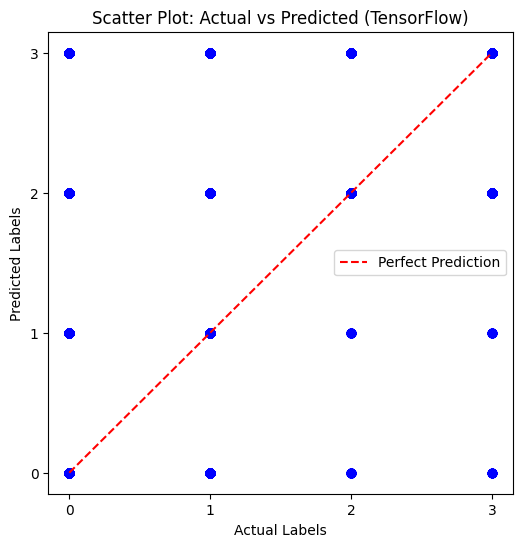

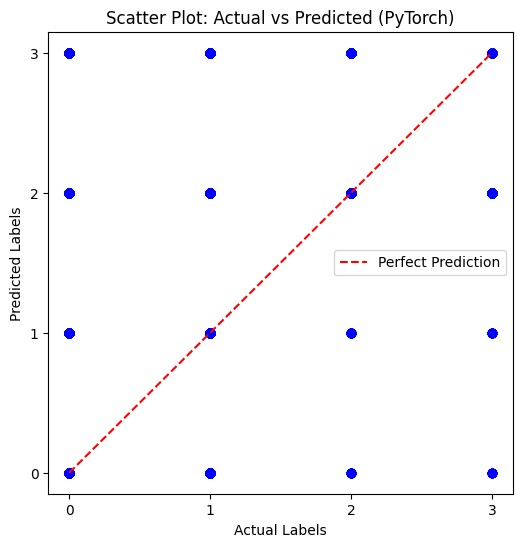

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_scatter(y_true, y_pred, model_name):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.3, color='blue')
    plt.plot([0, 3], [0, 3], '--', color='red', label="Perfect Prediction")  # Garis ideal
    plt.xlabel("Actual Labels")
    plt.ylabel("Predicted Labels")
    plt.title(f"Scatter Plot: Actual vs Predicted ({model_name})")
    plt.xticks(range(4))  # Pastikan hanya ada label 0, 1, 2, 3
    plt.yticks(range(4))
    plt.legend()
    plt.show()

# 🔥 Plot scatter untuk TensorFlow & PyTorch
plot_scatter(y_test, y_pred_tf, "TensorFlow")
plot_scatter(y_test, y_pred_torch, "PyTorch")


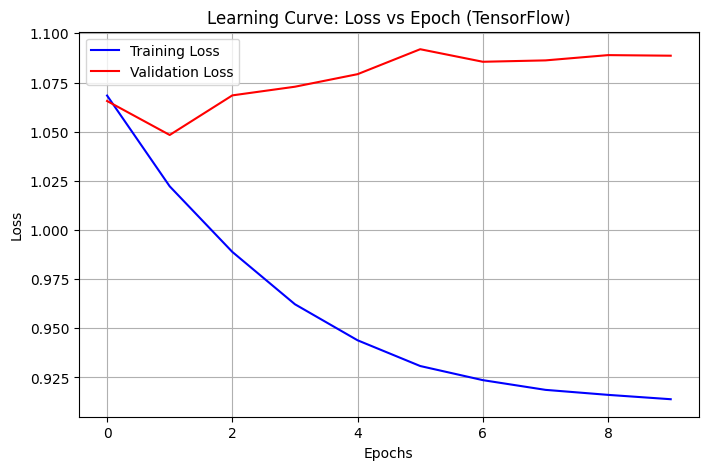

In [21]:
# 🔥 Learning Curve: Loss vs Epoch
plt.figure(figsize=(8, 5))
plt.plot(history_tf.history['loss'], label='Training Loss', color='blue')
plt.plot(history_tf.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve: Loss vs Epoch (TensorFlow)")
plt.legend()
plt.grid()
plt.show()


#**Penjelasan Singkat**

1️⃣ Akurasi (Accuracy)

Akurasi mengukur seberapa banyak prediksi yang benar dibandingkan dengan total prediksi.


Akurasi=

*TP+TN/
TP+TN+FP+FN*
​

📌 Keterangan:

TP (True Positive) → Prediksi benar sebagai positif.

TN (True Negative) → Prediksi benar sebagai negatif.

FP (False Positive) → Prediksi salah sebagai positif.

FN (False Negative) → Prediksi salah sebagai negatif.


2️⃣ Presisi (Precision)

Presisi mengukur seberapa akurat model dalam memprediksi kelas positif.

Presisi=
*TP/
TP+FP*



📌 Keterangan:

Jika model memiliki presisi tinggi, berarti model jarang salah dalam memprediksi kelas positif.

Jika presisi rendah, model sering salah memprediksi negatif sebagai positif (False Positive tinggi).

3️⃣ Recall (Sensitivitas)

Recall mengukur seberapa baik model dalam menangkap semua kasus positif.

Recall=
*TP/
TP+FN*


📌 Keterangan:

Jika recall tinggi, berarti model berhasil menangkap hampir semua data positif.
Jika recall rendah, model sering gagal mengenali positif sebagai negatif (False Negative tinggi).

4️⃣ F1-Score (Harmonic Mean)
F1-score menggabungkan presisi dan recall dalam satu metrik menggunakan rata-rata harmonik.

𝐹
1
=
2
×
Presisi
×
Recall/
Presisi
+
Recall

📌 Keterangan:

F1-score tinggi berarti model seimbang dalam presisi dan recall.

Bagus untuk dataset tidak seimbang, karena mempertimbangkan False Positive dan False Negative secara bersamaan.

5️⃣ Area Under Curve (AUC - ROC)
AUC (Area Under Curve) mengukur seberapa baik model membedakan antara kelas positif dan negatif.

AUC berasal dari ROC Curve, yang membandingkan True Positive Rate (TPR) vs False Positive Rate (FPR).

TPR
=
𝑇
𝑃/
𝑇
𝑃
+
𝐹
𝑁

(Sama dengan Recall)

*FPR=
FP/
FP+TN*

📌 Keterangan:

AUC = 1.0 → Model sempurna (memisahkan kelas dengan sempurna).
AUC = 0.5 → Model acak (tidak lebih baik dari tebak-tebakan).
AUC < 0.5 → Model lebih buruk dari acak (terbalik).

6️⃣ Receiver Operating Characteristic (ROC) Curve

ROC Curve adalah grafik yang membandingkan TPR vs FPR pada berbagai threshold.


Sumbu X → FPR (False Positive Rate)

Sumbu Y → TPR (True Positive Rate / Recall)

📌 Bagaimana membacanya?


Semakin tinggi kurva, semakin baik model.

ROC yang mendekati diagonal (AUC ≈ 0.5) berarti model tidak berguna.

##**Model evaluasi terbaik**


✅ 1️⃣ AUC - ROC (0.76)

Alasan: Model masih belum sempurna dalam klasifikasi, tetapi AUC menunjukkan bahwa model cukup bisa membedakan kelas.

✅ 2️⃣ F1-Score (38%)

Alasan: Dataset tidak seimbang, sehingga kita harus mempertimbangkan False Positives & False Negatives.
